Predictions
===========

We can now create our final script to process an input image:
- take an image as input
- detect what's on the image
    - use Human detector (opencv)
    - use Pokemon detector (pytorch model)
- use the trained Pokemon classifier to give the name of the Pokémon (if it's a Pokémon), 
or the Pokémon it looks like (if it's a Human or something else)

In [1]:
from datetime import datetime

import matplotlib.image as mpimg
import torch
from PIL import Image
from torch.autograd import Variable

In [2]:
import utils
import conf

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir='data/Pokemon'

/home/bazema/workspace/venv_pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
transform, _,_  = utils.torch_transformations()


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = transform['test'](image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

In [5]:
def predict(model_path, image_path, classes):
    model_detector=torch.load(model_path)
    image = image_loader(image_path)
    output = model_detector(image)
    index = output.data.cpu().numpy().argmax()
    return classes[index]

In [8]:
predict('pokemon_classifier.pth', '../data/Pokemon/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg', conf.pokemons)

'Exeggutor'

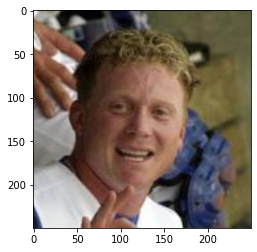

It's a Human, it looks like the Pokemon Pinsir !
Took 0:00:00.723251 to predict


FileNotFoundError: [Errno 2] No such file or directory: 'data/Pokemon/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg'

In [10]:


def human_detector(image_path):
    return utils.face_detector(image_path)

def detect_pokemon(image_path):
    return predict('pokemon_detector.pth', image_path, conf.detector_classes)

def pokemon_classifier(image_path):
    return predict('pokemon_classifier.pth', image_path, conf.pokemons)

def pokemon_identificator(image_path):
    img = mpimg.imread(image_path)
    utils.imshow(img)
    
    start = datetime.now()
    res_detector = detect_pokemon(image_path)
    res_classifier = pokemon_classifier(image_path)
    
    if utils.face_detector(image_path):
        print(f'It\'s a Human, it looks like the Pokemon {res_classifier} !')
    elif res_detector == 'Pokemon':
        print(f'It\'s a Pokemon: {res_classifier} !')
    else:
        print(f'It doesn\'t look like a Pokemon nor a Human, but it looks like {res_classifier} !')
        
    print(f'Took {datetime.now() - start} to predict')

pokemon_identificator('../data/lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg')
pokemon_identificator('data/Pokemon/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg')
pokemon_identificator('data/Pokemon/Exeggcute/58983b10ed8e423a9c42473ae0157745.jpg')
pokemon_identificator('data/lfw/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg')
pokemon_identificator('data/lfw/Abdoulaye_Wade/Abdoulaye_Wade_0002.jpg')
pokemon_identificator('data/lfw/Abdoulaye_Wade/Abdoulaye_Wade_0003.jpg')
pokemon_identificator('data/lfw/Abdoulaye_Wade/Abdoulaye_Wade_0004.jpg')
pokemon_identificator('chicken.jpeg')